# Angles of Lorenz 63

In this notebook we will plot the basic facts about the angles between different CLVs of Lorenz 63

## Utilities

### Work will be based on raw data from the run below

In [1]:
data_directory = 'tau0.1-steps1.1E+06KUPTSOV' # Where the data is

In [17]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc # Latex for plots
from scipy.interpolate import interp1d
rc('text', usetex=True)

from scipy.stats import gaussian_kde
from scipy.linalg import subspace_angles

### Class for Reading and Processing Data.

This class reads in data from a L63 Ginelli run. You specify the number of steps you want the FTLEs to be averaged over as well as how many samples you want. It processes both.

In [4]:
class DataRead: # THINK ABOUT BENEFITS OF THIS BEING READ AS PD ARRAY 
    """Class for reading data from a L63 Lyapunov Analysis run
    Parameter, directory, string: Directory containing data files.
    Parameter, L, integer: L * tau is the averaging time for the FTLES. 
    Parameter, s, integer: number of times we sample the FTLEs.
    """

    def __init__(self, dirName, L, s): # Add a load feature, as processing is slow
        self.directory = dirName
        
        # FTLE
        
        # Reading raw FTLE Data, this corresponds to averaging time = QR time of the run
        self.raw_FTBLE = np.load(dirName + '/Data/FTBLE.npy') # This is for L = 1, i.e. growth just over time tau
        self.raw_FTCLE = np.load(dirName + '/Data/FTCLE.npy')
        
        # Processing FTLE Data, i.e longer averaging times
        self.all_FTBLE = self.process(self.raw_FTBLE, L) # Remember FTLEs indexed by (time, LE index)
        self.all_FTCLE = self.process(self.raw_FTCLE, L) # Of course here time is in steps of averaging time
        
        # Sampling FTLEs Randomly
        self.sample_index = np.random.choice(self.all_FTBLE.shape[0], s, replace=False)
        if (s == self.all_FTBLE.shape[0]): # In case you just sample all the indices
            self.FTBLE = self.all_FTBLE 
            self.FTCLE = self.all_FTCLE
        else:
            self.FTBLE = self.all_FTBLE[self.sample_index] # DANGER! When sampled randomly like this, they're not in order
            self.FTCLE = self.all_FTCLE[self.sample_index]

#         self.CLE = np.load(dirName + '/Data/CLE.npy') # Don't really need this atm
#         self.BLE = np.load(dirName + '/Data/BLE.npy')

        # LVs
    
        self.raw_CLV = np.load(dirName + '/Data/CLVs.npy') # Raw CLV indexed by (time, row, column)
        self.raw_BLV = np.load(dirName + '/Data/BLVs.npy') 
        
        # LV at averaging timesteps. [0] index is starting LV (not stretched)
        self.all_CLV = np.append([self.raw_CLV[0]], self.raw_CLV[L: : L], axis =0) # FTLE first average after L steps. Notice one less CLV matrix than FTLE
        self.all_BLV = np.append([self.raw_BLV[0]], self.raw_BLV[L: : L], axis =0) # These are BLV matrices
        
        # Samples, these are the LVs corresponding to the samples LEs
        if (s == self.all_FTBLE.shape[0]):
            self.CLV = self.all_CLV
            self.BLV = self.all_BLV
        else:
            self.CLV = self.all_CLV[self.sample_index] 
            self.BLV = self.all_BLV[self.sample_index] 

        # Solution
        self.solution = np.load(dirName + '/Data/solution.npy')
        
        # Some info
        infile = open(self.directory +'/parameters','rb')
        self.param_dict = pickle.load(infile) # Dictionary of parameters used to generate the data
        infile.close()
        
        self.avg_time = L # Averaging time
        self.samples = s 

    def who(self):
        "Prints the parameters associated with the run."
        print(f'The parameters used to generate this data were:\n{self.param_dict}\n')
        print(f'Processing parameters for this data:\n{self.processing_dict()}')
        return
    
    def processing_dict(self):
        "Returns a dictionary with info on how the raw data was processed."
        p_dict = {'Samples': self.samples,
                 'Averaging Time': self.avg_time * self.param_dict['tau']}
        return p_dict
    
    def raw_stats(self):
        "Returns a dictionary with summary statistics from the raw run."
        ss_dict ={'FTBLE Means': np.mean(self.rawFTBLE, axis = 0),
                  'FTCLE Means': np.mean(self.rawFTCLE, axis = 0),
                  'CLE Check Sum': np.sum( np.mean(self.rawFTBLE, axis = 0) ),
                  'BLE Check Sum': np.sum( np.mean(self.rawFTCLE, axis = 0) )}
        return ss_dict
    
    def sample_stats(self):
        "Returns a dictionary with summary statistics from the sampled data."
        ss_dict ={'FTBLE Means': np.mean(self.FTBLE, axis = 0),
                  'FTCLE Means': np.mean(self.FTCLE, axis = 0),
                  'CLE Check Sum': np.sum( np.mean(self.FTBLE, axis = 0) ),
                  'BLE Check Sum': np.sum( np.mean(self.FTCLE, axis = 0) )}
        return ss_dict
    
    def process(self, raw, L): # THIS IS SLOW
        FTLE = [[np.mean(raw[0:L, 0]), np.mean(raw[0:L, 1]), np.mean(raw[0:L, 2])]]
        for i in range(L, len(raw) - len(raw)%L , L):
            # If L doesn't divide len(raw) exactly, we throw away last block less than length L
            means = [ [np.mean(raw[i:i + L, 0]) , np.mean(raw[i:i + L, 1]) , np.mean(raw[i:i + L, 2])] ]
            FTLE = np.append(FTLE, means, axis = 0)
        return FTLE
          

## Angle Utilities

In [5]:
# Needed for tangent vector calculation

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

In [6]:
# Needed for angles between individual CLVs

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Defining a Class for Calculating Angles

When you create an angle class it has everything you need in it. Be warned, they are slow to make.

In [39]:
class Angles:
    """Class for calculating various angles from a L63 Lyapunov Analysis run.
    Relies on subspace_angles, angle_between and L63 functions.
    Parameter, data, DataRead: Read in Data from a run.
    Option, string: directory to load angles if already calculated.
    """

    def __init__(self, data, load = 'Generate'):
        self.directory = data.directory + '/Data/'
        self.CLV = data.CLV
        self.BLV = data.BLV
        self.solution = data.solution
        self.param_dict = data.param_dict
        self.processing_dict = data.processing_dict()
        self.samples = data.samples
        if (load == 'Generate'): # These three function calls here will make object generation slow
            self.spaces = self.spaces() 
            self.vectors = self.vectors()
            #self.tangent = self.tangent()
            print('Save the data')
        else:
            self.load(load)

    def who(self):
        "Prints the parameters associated with the run."
        print(f'The parameters used to generate this data were:\n{self.param_dict}')
        return
    
    def spaces(self):
        """Function for calculating angles between expanding and contracting CLV subspaces.
        param, data: data from run.
        """
        angles = np.zeros((self.samples, 2)) # You will have to think about changing this when you have more CLVs
        for t in np.arange(self.samples):
            angles[t, 0] = subspace_angles(self.CLV[t, :, [0]].T, self.CLV[t, :, 1:])[0] # Angle between 1 and non-expanding
            angles[t, 1] = subspace_angles(self.CLV[t, :, :2], self.CLV[t, :, [2]].T)[0]
        return angles
    
    def vectors(self):
        """ Calculates angles between each pair of CLVs. Indexed by [time, (angle of:) (1,2), (1,3), (2,3)]
        """
        kB = self.param_dict['kB']
        CLV = self.CLV
        CLVangles = np.zeros((self.samples, 3)) # Indexed by [time, (angle of:) (1,2), (1,3), (2,3)]

        for t in np.arange(self.samples):
            CLVangles[t, 0] = angle_between(CLV[t,:,0], CLV[t,:,1])
            CLVangles[t, 1] = angle_between(CLV[t,:,0], CLV[t,:,2])
            CLVangles[t, 2] = angle_between(CLV[t,:,1], CLV[t,:,2])
        return CLVangles
    
#     def tangent(self): This needs redesigning
#         """Function for calculating CLV angle with tangent vector, in degrees.
#         param, data: data from run.
#         """
#         ctangles = np.zeros(self.param_dict['kB'])
#         tA = int(self.param_dict['dt'] * self.param_dict['kA'])
#         step = 0
#         a, b, c = self.param_dict['a'], self.param_dict['b'], self.param_dict['c']
#         p = np.array([a, b, c])
#         for t in np.arange(self.param_dict['kB']):
#             step = tA + (int(t * self.param_dict['tao']))
#             state = self.solution[step]
#             tangent = L63(state, 1, p) # THINK ABOUT WHETHER THIS IS CORRECT
#             ctangles[t] = np.rad2deg(subspace_angles(self.CLVs[t, :, :2], np.array([tangent]).T)[0])
#             #btangles[t] = np.rad2deg(subspace_angles(BLVs[t, :, :2], np.array([tangent]).T)[0])
#         return ctangles
    
    def save(self, dirName):
        """ Function saving object data. Can then be reloaded in future
        Parameter, string, dirName: Where we will save the data.
        """
        np.save(dirName + '/Data/angle-spaces', self.spaces)
        np.save(dirName + '/Data/angle-vectors', self.vectors)
        #np.save(dirName + '/Data/angle-tangent', self.tangent)
        return
    
    def load(self, dirName):
        """ Function to load object data if it exists.
        """
        self.spaces = np.load(dirName + '/Data/angle-spaces.npy')
        self.vectors = np.load(dirName + '/Data/angle-vectors.npy')
        #self.tangent = np.load(dirName + '/Data/angle-tangent.npy')
        return

          

### Reading Data 

In [33]:
run_data = DataRead('tau0.1-steps1.1E+06KUPTSOV', 160, 1000) # Issue with saving data changes type
# np.save(data_directory + '/Data/Angle-Data', run_data)
#run_data = np.load(data_directory + '/Data/Angle-Data.npy', allow_pickle = True)
type(run_data)

__main__.DataRead

### Calculating Angles

Make sure to save the angles after you calculate them.

In [40]:
# Space for calculating angles
angle_data = Angles(run_data)

Save the data


In [42]:
angle_data.save(data_directory)

In [ ]:
# Space for Saving angles
# tao500angles.save('tao0.5-length2.4E+04')

# Density of Angles between Subspaces

Here we plot the density of the angle between the expanding and contracting subspaces (see Kuptsov).

In [87]:
theta_1_data = angle_data.spaces[:, 0] # Degrees, angle between first CLV and non-expanding spaces
theta_2_data = angle_data.spaces[:, 1] # Degrees, angle between non-contracting spaces and last CLV

### KDE Estimator

In [98]:
x_1 = np.linspace(theta_1_data.min(), theta_1_data.max(), 1000) # Grid we evaluate PDF on. 1000 points between 0 and 90 degrees
x_2 = np.linspace(theta_2_data.min(), theta_2_data.max(), 1000) # Grid we evaluate PDF on. 1000 points between 0 and 90 degrees
kde1 = gaussian_kde(theta_1_data) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw? 
kde2 = gaussian_kde(theta_2_data) 
pdf1 = kde1.evaluate(x_1)
pdf2 = kde2.evaluate(x_2)

Plotting Densities

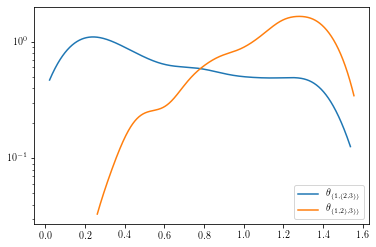

In [131]:
plt.plot(x_1, pdf1, label = '$\\theta_{(1, (2,3))}$')
plt.plot(x_2, pdf2, label = '$\\theta_{(1,2) ,3))}$')
plt.yscale('log')
plt.legend()

### Rate Functions

From this you get agreement with Kuptsov that CLV 1 is sometimes in non expanding space but CLV 3 is never in the non contracting space

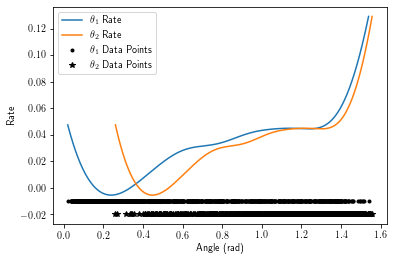

In [112]:
Ltau = 16
rate1 = - (np.log(pdf1) / Ltau)
rate2 = - (np.log(pdf1) / Ltau)
plt.plot(x_1, rate1, label = '$\\theta_1$ Rate')
plt.plot(x_2, rate2, label = '$\\theta_2$ Rate')
plt.xlabel('Angle (rad)')
plt.ylabel('Rate')
plt.plot(theta_1_data, np.full_like(theta_1_data, - 0.01), '.k', label = '$\\theta_1$ Data Points')
plt.plot(theta_2_data, np.full_like(theta_2_data, - 0.02), '*k', label = '$\\theta_2$ Data Points')
plt.legend()
plt.show()

# Individual Angles

Reading data of angles between individual CLVs

In [113]:
angles_1_2 = angle_data.vectors[:, 0] 
angles_1_3 = angle_data.vectors[:, 1] 
angles_2_3 = angle_data.vectors[:, 2] 

### KDE Estimator

In [126]:
x_d = np.linspace(0, 3.14, 100) # Grid we evaluate PDF on. 1000 points between 0 and 180 degrees
kde12 = gaussian_kde(angles_1_2) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw? 
kde13 = gaussian_kde(angles_1_3) 
kde23 = gaussian_kde(angles_2_3) 
pdf12 = kde12.evaluate(x_d)
pdf13 = kde13.evaluate(x_d)
pdf23 = kde23.evaluate(x_d)

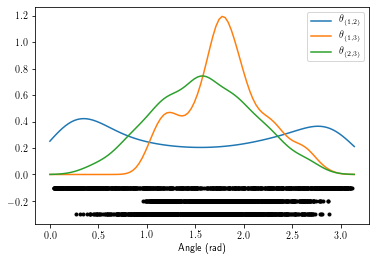

In [130]:
plt.plot(x_d, pdf12, label = '$\\theta_{(1,2)}$')
plt.plot(x_d, pdf13, label = '$\\theta_{(1,3)}$')
plt.plot(x_d, pdf23, label = '$\\theta_{(2,3)}$')
plt.plot(angles_1_2, np.full_like(angles_1_2, - 0.1), '.k')
plt.plot(angles_1_3, np.full_like(angles_1_3, - 0.2), '.k')
plt.plot(angles_2_3, np.full_like(angles_2_3, - 0.3), '.k')
plt.xlabel('Angle (rad)')
plt.legend()
plt.show()

From the above we see CLV 1 and CLV 2 are sometimes tangent, in general almost uniform distribution of angles between them.

CLV 1 and 3 are never tangent, they're largely perpendicular although angle does fluctuate.

CLV 2 and 3 are alsor never tangent although they have a larger range of angles between them.

### Rates

y Axis small


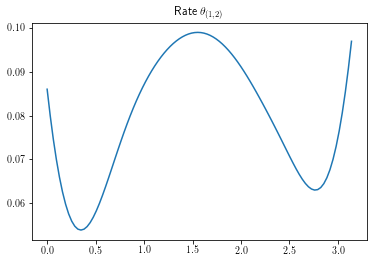

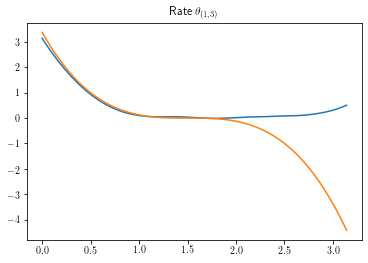

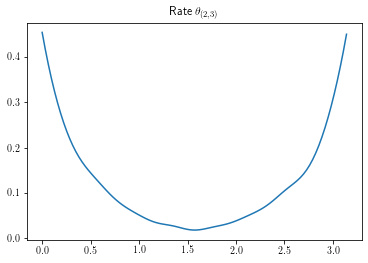

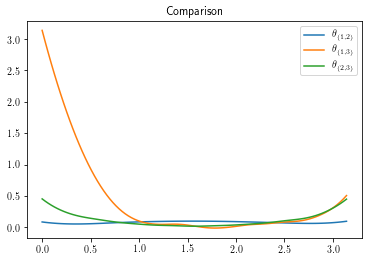

In [156]:
rate12 = - (np.log(pdf12) / Ltau)
rate13 = - (np.log(pdf13) / Ltau)
rate23 = - (np.log(pdf23) / Ltau)
plt.title('Rate $\\theta_{(1,2)}$')
plt.plot(x_d, rate12)
print('y Axis small')
plt.figure()
plt.title('Rate $\\theta_{(1,3)}$')
plt.plot(x_d, rate13)
plt.plot(x_d, -(x_d - 1.5)**3)
plt.figure()
plt.title('Rate $\\theta_{(2,3)}$')
plt.plot(x_d, rate23)
plt.figure()
plt.plot(x_d, rate12, label = '$\\theta_{(1,2)}$')
plt.plot(x_d, rate13, label = '$\\theta_{(1,3)}$')
plt.plot(x_d, rate23, label = '$\\theta_{(2,3)}$')
plt.title('Comparison')
plt.legend()
plt.show()

### Conclusions

In summary, expanding direction always isolated from the contracting one, but not the neutral one. 

The contracting direction is always isolated from both neutral and expanding directions. 